In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, RobustScaler, OrdinalEncoder
from sklearn.manifold import TSNE, MDS
from sklearn.decomposition import PCA


In [2]:
df = pd.read_csv('bank.csv')


In [3]:
df.head()


age          job   marital  education default  balance housing loan  \
0  32.0   technician    single   tertiary      no      392     yes   no   
1  39.0   technician  divorced  secondary      no      688     yes  yes   
2  59.0      retired   married  secondary      no     1035     yes  yes   
3  47.0  blue-collar   married  secondary      no      398     yes  yes   
4  54.0      retired   married  secondary      no     1004     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome  \
0  cellular    1   apr       957         2    131         2  failure   
1  cellular    1   apr       233         2    133         1  failure   
2  cellular    1   apr       126         2    239         1  failure   
3  cellular    1   apr       274         1    238         2  failure   
4  cellular    1   apr       479         1    307         1  failure   

  subscribed  
0         no  
1         no  
2         no  
3         no  
4         no

In [4]:
class OutlierCapperIQR(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass

    def fit(self, X, y=None):
        Q1 = np.percentile(X, 25, axis=0)
        Q3 = np.percentile(X, 75, axis=0)
        IQR = Q3 - Q1
        self.lower_bound_ = Q1 - 3 * IQR
        self.upper_bound_ = Q3 + 3 * IQR
        return self

    def transform(self, X):
        X_capped = np.clip(X, self.lower_bound_, self.upper_bound_)
        return X_capped

class KNNImputerWithSpecifiedColumns(BaseEstimator, TransformerMixin):
    def __init__(self, neighbor_cols):
        self.neighbor_cols = neighbor_cols
        self.encoder = OrdinalEncoder()
        self.imputer = KNNImputer()

    def fit(self, X, y=None):
        neighbor_data_encoded = self.encoder.fit_transform(X[self.neighbor_cols])
        self.imputer.fit(np.hstack([X[['age']], neighbor_data_encoded]))
        return self

    def transform(self, X):
        neighbor_data_encoded = self.encoder.transform(X[self.neighbor_cols])
        imputed_data = self.imputer.transform(np.hstack([X[['age']], neighbor_data_encoded]))
        return imputed_data[:, 0].reshape(-1, 1)

class AgeBinner(BaseEstimator, TransformerMixin):
    def __init__(self, bins=[0, 20, 30, 40, 50, 60, np.inf], labels=['Under_20', '20-29', '30-39', '40-49', '50-59', '60_and_above']):
        self.bins = bins
        self.labels = labels

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        X_binned = pd.cut(X.iloc[:, 0], bins=self.bins, labels=self.labels, right=False)
        return pd.get_dummies(X_binned, drop_first=True).to_numpy()

numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols.remove('balance')
numerical_cols.remove('age')

balance_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('outlier_capper', OutlierCapperIQR()),
    ('scaler', RobustScaler())
])

age_pipeline = Pipeline([
    ('knn_imputer', KNNImputerWithSpecifiedColumns(['marital', 'job', 'education', 'housing', 'contact'])),
    ('age_binner', AgeBinner())
])

categorical_plus_age_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

full_pipeline = ColumnTransformer([
    ('balance_processing', balance_pipeline, ['balance']),
    ('num', RobustScaler(), numerical_cols),
    ('age_binning', age_pipeline, ['age', 'marital', 'job', 'education', 'housing', 'contact']),
    ('cat', categorical_plus_age_pipeline, categorical_cols)
], remainder='passthrough')


In [5]:
transformed_data = full_pipeline.fit_transform(df)

cat_features = full_pipeline.named_transformers_['cat'].named_steps['encoder'].get_feature_names_out(categorical_cols)

age_bins_labels = ['age_binned_' + lbl for lbl in ['20-29', '30-39', '40-49', '50-59', '60_and_above']]

numerical_features = ['balance_capped'] + numerical_cols

new_features = numerical_features + age_bins_labels + list(cat_features)

transformed_df = pd.DataFrame(transformed_data, columns=new_features)

print(transformed_df.head())


   balance_capped       day  duration  campaign     pdays  previous  \
0       -0.110187 -0.611111  3.094421       1.0 -0.291013       0.0   
1        0.094941 -0.611111 -0.012876       1.0 -0.279601      -0.5   
2        0.335412 -0.611111 -0.472103       1.0  0.325250      -0.5   
3       -0.106029 -0.611111  0.163090       0.0  0.319544       0.0   
4        0.313929 -0.611111  1.042918       0.0  0.713267      -0.5   

   age_binned_20-29  age_binned_30-39  age_binned_40-49  age_binned_50-59  \
0               0.0               1.0               0.0               0.0   
1               0.0               1.0               0.0               0.0   
2               0.0               0.0               0.0               1.0   
3               0.0               0.0               1.0               0.0   
4               0.0               0.0               0.0               1.0   

   ...  month_may  month_nov  month_oct  month_sep  poutcome_failure  \
0  ...        0.0        0.0        0.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

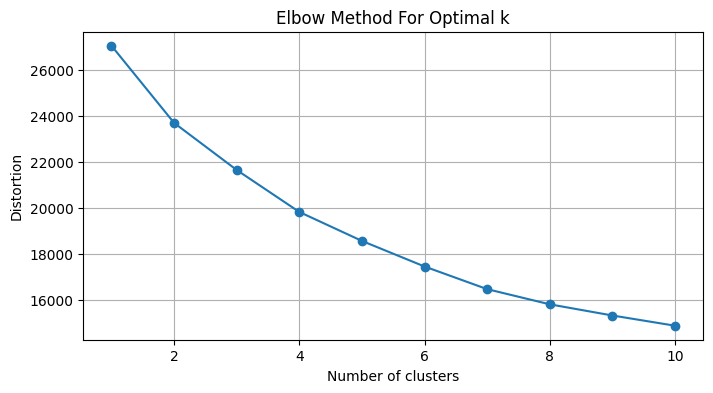

In [6]:
from sklearn.cluster import KMeans

def plot_elbow_method(X, k_range):
    distortions = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        kmeans.fit(X)
        distortions.append(kmeans.inertia_)

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, distortions, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Distortion')
    plt.title('Elbow Method For Optimal k')
    plt.grid(True)
    plt.show()

plot_elbow_method(transformed_data, range(1, 11))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

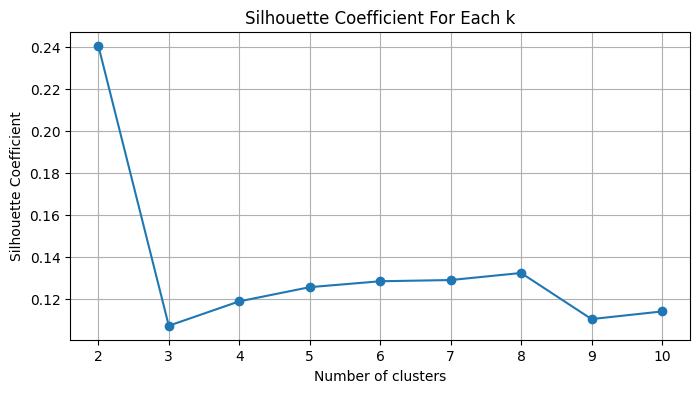

In [7]:
from sklearn.metrics import silhouette_score

def plot_silhouette_coefficients(X, k_range):
    scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k)
        cluster_labels = kmeans.fit_predict(X)
        score = silhouette_score(X, cluster_labels)
        scores.append(score)

    plt.figure(figsize=(8, 4))
    plt.plot(k_range, scores, marker='o')
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Coefficient')
    plt.title('Silhouette Coefficient For Each k')
    plt.grid(True)
    plt.show()

plot_silhouette_coefficients(transformed_data, range(2, 11))


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


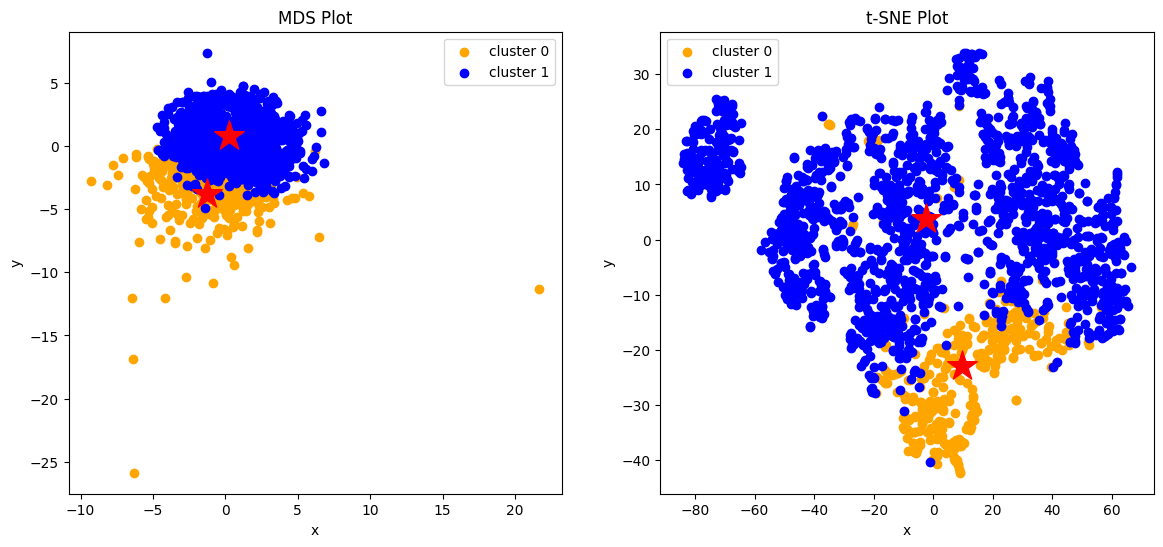

In [8]:
colors = np.array(['orange', 'blue', 'lime', 'khaki', 'pink', 'green', 'purple'])

def clustering_scatterplot(points, labels, centers, title):
    n_clusters = np.unique(labels).size
    for i in range(n_clusters):
        plt.scatter(points[labels==i,0], points[labels==i,1], c=colors[i%colors.size], label='cluster '+str(i))
    if centers is not None:
        plt.scatter(centers[:,0], centers[:,1], c='red', marker='*', s=500)
    plt.title(title)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')

def plot_mds_tsne(X, labels):
    mds = MDS(n_components=2, random_state=42)
    X_mds = mds.fit_transform(X)
    tsne = TSNE(n_components=2, random_state=42)
    X_tsne = tsne.fit_transform(X)

    # Compute cluster centers for MDS and t-SNE
    centers_mds = np.array([X_mds[labels == i].mean(axis=0) for i in np.unique(labels)])
    centers_tsne = np.array([X_tsne[labels == i].mean(axis=0) for i in np.unique(labels)])

    plt.figure(figsize=(14, 6))
    plt.subplot(1, 2, 1)
    clustering_scatterplot(X_mds, labels, centers_mds, 'MDS Plot')

    plt.subplot(1, 2, 2)
    clustering_scatterplot(X_tsne, labels, centers_tsne, 't-SNE Plot')

    plt.show()

pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(transformed_data)

kmeans = KMeans(n_clusters=2)
labels = kmeans.fit_predict(X_pca)

plot_mds_tsne(X_pca, labels)
